In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Food and ingredients from Wikidata

In [9]:

df_raw = pd.read_csv("Downloads/query3.csv", index_col=None, header=0)

In [10]:
df = pd.DataFrame()
df['food'] = df_raw['food']
df['food_name'] = df_raw['foodLabel']
df['ingredient_id'] = df_raw['mother']
df['ingredient_name'] = df_raw['label_clean']
df['origin_id'] = df_raw['father']
df['origin_name'] = df_raw['fatherLabel']
df['ingredient_category'] = df_raw['category']
df

food food_name  \
0     http://www.wikidata.org/entity/Q100255672      moho   
1     http://www.wikidata.org/entity/Q100255672      moho   
2     http://www.wikidata.org/entity/Q100255672      moho   
3     http://www.wikidata.org/entity/Q100255672      moho   
4     http://www.wikidata.org/entity/Q100529246    punten   
...                                         ...       ...   
2387    http://www.wikidata.org/entity/Q7211268  Luosifen   
2388    http://www.wikidata.org/entity/Q7211268  Luosifen   
2389     http://www.wikidata.org/entity/Q878624    congee   
2390     http://www.wikidata.org/entity/Q878624    congee   
2391   http://www.wikidata.org/entity/Q96440087   guǒtiáo   

                                ingredient_id ingredient_name origin_id  \
0       http://www.wikidata.org/entity/Q11002           sugar       NaN   
1      http://www.wikidata.org/entity/Q841779    coconut milk       NaN   
2     http://www.wikidata.org/entity/Q1269205      rice flour       NaN   
3     http://www.wikidata.org/entity/Q2249305     wheat flour       NaN   
4       http://www.wikidata.org/entity/Q11254            salt       NaN   
...                                       ...             ...       ...   
2387  http://www.wikidata.org/entity/Q3621199             NaN       NaN   
2388  http://www.wikidata.org/entity/Q4500803             NaN       NaN   
2389     http://www.wikidata.org/entity/Q5090             NaN       NaN   
2390     http://www.wikidata.org/entity/Q5090             NaN       NaN   
2391  http://www.wikidata.org/entity/Q1322949             NaN       NaN   

     origin_name ingredient_category  
0            NaN               spice  
1            NaN              fruits  
2            NaN               flour  
3            NaN               flour  
4            NaN               spice  
...          ...                 ...  
2387         NaN                 NaN  
2388         NaN                 NaN  
2389         NaN                 NaN  
2390         NaN                 NaN  
2391         NaN                 NaN  

[2392 rows x 7 columns]

# Creating Database

In [11]:
import sqlite3 as sl


In [12]:
con = sl.connect('test_db.db')


In [13]:
with con:
    con.execute("""
        CREATE TABLE IF NOT EXISTS FOOD_INGREDIENT (
            food TEXT NOT NULL,
            food_name TEXT,
            ingredient_id TEXT,
            ingredient_name TEXT,
            origin_id TEXT,
            origin_name TEXT,
            ingredient_category TEXT
        );
    """)

In [14]:
data = df.values.tolist()
len(data)

2392

In [15]:
sql = 'INSERT INTO FOOD_INGREDIENT (food, food_name, ingredient_id, ingredient_name, origin_id, origin_name, ingredient_category) values(?, ?, ?, ?, ?, ?, ?)'


In [16]:
with con:
    con.executemany(sql, data)

In [17]:
#WHERE food_name = 'cenil'
with con:
    data = con.execute("SELECT * FROM FOOD_INGREDIENT")
    for row in data:
        print(row)
        

('http://www.wikidata.org/entity/Q100255672', 'moho', 'http://www.wikidata.org/entity/Q11002', 'sugar', None, None, 'spice')
('http://www.wikidata.org/entity/Q100255672', 'moho', 'http://www.wikidata.org/entity/Q841779', 'coconut milk', None, None, 'fruits')
('http://www.wikidata.org/entity/Q100255672', 'moho', 'http://www.wikidata.org/entity/Q1269205', 'rice flour', None, None, 'flour')
('http://www.wikidata.org/entity/Q100255672', 'moho', 'http://www.wikidata.org/entity/Q2249305', 'wheat flour', None, None, 'flour')
('http://www.wikidata.org/entity/Q100529246', 'punten', 'http://www.wikidata.org/entity/Q11254', 'salt', None, None, 'spice')
('http://www.wikidata.org/entity/Q100529246', 'punten', 'http://www.wikidata.org/entity/Q115443', 'glutinous rice', None, None, 'carb')
('http://www.wikidata.org/entity/Q100529246', 'punten', 'http://www.wikidata.org/entity/Q841779', 'coconut milk', None, None, 'fruits')
('http://www.wikidata.org/entity/Q101432536', 'Lemonilo', None, None, None, No

# Data Preprocessing

In [18]:
df = pd.read_sql_query("SELECT food_name, group_concat(replace(ingredient_name,' ','_'), ' ') as ingredient_list from (select distinct food_name, ingredient_name from FOOD_INGREDIENT) group by 1", con)
df.shape
df = df.dropna()

In [19]:
total_ingredient = pd.read_sql_query("SELECT ingredient_name, ingredient_category, count(distinct food_name) from FOOD_INGREDIENT where ingredient_name is not null group by 1,2 order by 3 desc", con)
total_ingredient

ingredient_name ingredient_category  count(distinct food_name)
0      coconut milk              fruits                         63
1              salt               spice                         59
2             sugar               spice                         44
3            garlic               spice                         35
4        palm sugar           seasoning                         34
..              ...                 ...                        ...
508    walnut shell        walnut shell                          1
509   white cabbage          vegetables                          1
510            wine                wine                          1
511           yeast               yeast                          1
512            yolk       dairy and egg                          1

[513 rows x 3 columns]

In [20]:
ingredient_in_list = [ingredient.split() for ingredient in df.ingredient_list]


In [21]:
import nltk
from nltk import bigrams

# Create list of lists containing bigrams in tweets
terms_bigram = [list(bigrams(tweet)) for tweet in ingredient_in_list]

# View bigrams for the first tweet
terms_bigram[0]

[]

In [22]:
import itertools
import collections

# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

bigram_counts.most_common(20)

[(('sugar', 'salt'), 22),
 (('coconut_milk', 'rice_flour'), 14),
 (('Central_Java', 'Jepara'), 14),
 (('glutinous_rice', 'coconut_milk'), 7),
 (('rice_flour', 'wheat_flour'), 7),
 (('pandan', 'coconut_milk'), 7),
 (('coconut_milk', 'palm_sugar'), 6),
 (('salt', 'coconut_milk'), 6),
 (('sugar', 'coconut_milk'), 6),
 (('palm_sugar', 'coconut'), 6),
 (('palm_sugar', 'cassava'), 6),
 (('salt', 'chili'), 5),
 (('salt', 'garlic'), 5),
 (('rice_flour', 'coconut'), 5),
 (('water', 'salt'), 5),
 (('sugar', 'glutinous_rice'), 4),
 (('coconut_milk', 'glutinous_rice_flour'), 4),
 (('coconut', 'glutinous_rice_flour'), 4),
 (('Central_Java', 'East_Java'), 4),
 (('onion', 'garlic'), 4)]

In [23]:
from collections import defaultdict

def co_occurrence(sentences, window_size):
    d = defaultdict(int)
    vocab = set()
    for text in sentences:
        # preprocessing
        text = text.lower().split()
        # iterate over ingredient list
        for i in range(len(text)):
            token = text[i]
            vocab.add(token)  # add to vocab
            next_token = text[i+1 : i+1+window_size]
            for t in next_token:
                key = tuple( sorted([t, token]) )
                d[key] += 1
    
    # formulate the dictionary into dataframe
    vocab = sorted(vocab) # sort vocab
    df = pd.DataFrame(data=np.zeros((len(vocab), len(vocab)), dtype=np.int16),
                      index=vocab,
                      columns=vocab)
    for key, value in d.items():
        df.at[key[0], key[1]] = value
        df.at[key[1], key[0]] = value
    return df

In [24]:
df_test = co_occurrence(df.ingredient_list, 2)
df_test.shape

(435, 435)

In [25]:
df_temp = df_test


In [26]:
columns = list(df_temp)
len(columns)

435

In [27]:
df_compiled = pd.DataFrame(columns=['bigram','count'])

for i,row in df_test.iterrows():
    for j in columns:
        if row[j] > 0:
            bigram_name = (i,j)
            reverse_bigram_name = (j,i)
            bigram_value = row[j]
            df_t = pd.DataFrame(columns=['bigram','count'])
            df_t.loc[-1] = [bigram_name, bigram_value]
            if df_compiled[df_compiled['bigram']==reverse_bigram_name].empty == False:
                print('')
            else:
                df_compiled = df_compiled.append(df_t, ignore_index = True)

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)


C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled 

C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)


C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)


C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)
C:\Users\sahar\AppData\Local\Temp\ipykernel_11452\104974552.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_compiled = df_compiled.append(df_t, ignore_index = True)


In [28]:
df_compiled = df_compiled.sort_values(by=['count'], ascending=False)
df_compiled.shape

(1036, 2)

In [29]:
import networkx as nx


In [30]:
d = df_compiled.set_index('bigram').T.to_dict('records')
len(d[0].values())

1036

In [31]:
G = nx.Graph()
c=0
# Create connections between nodes
for k, v in d[0].items():
    c = c+1
    G.add_edge(k[0], k[1], weight=(v * 10))

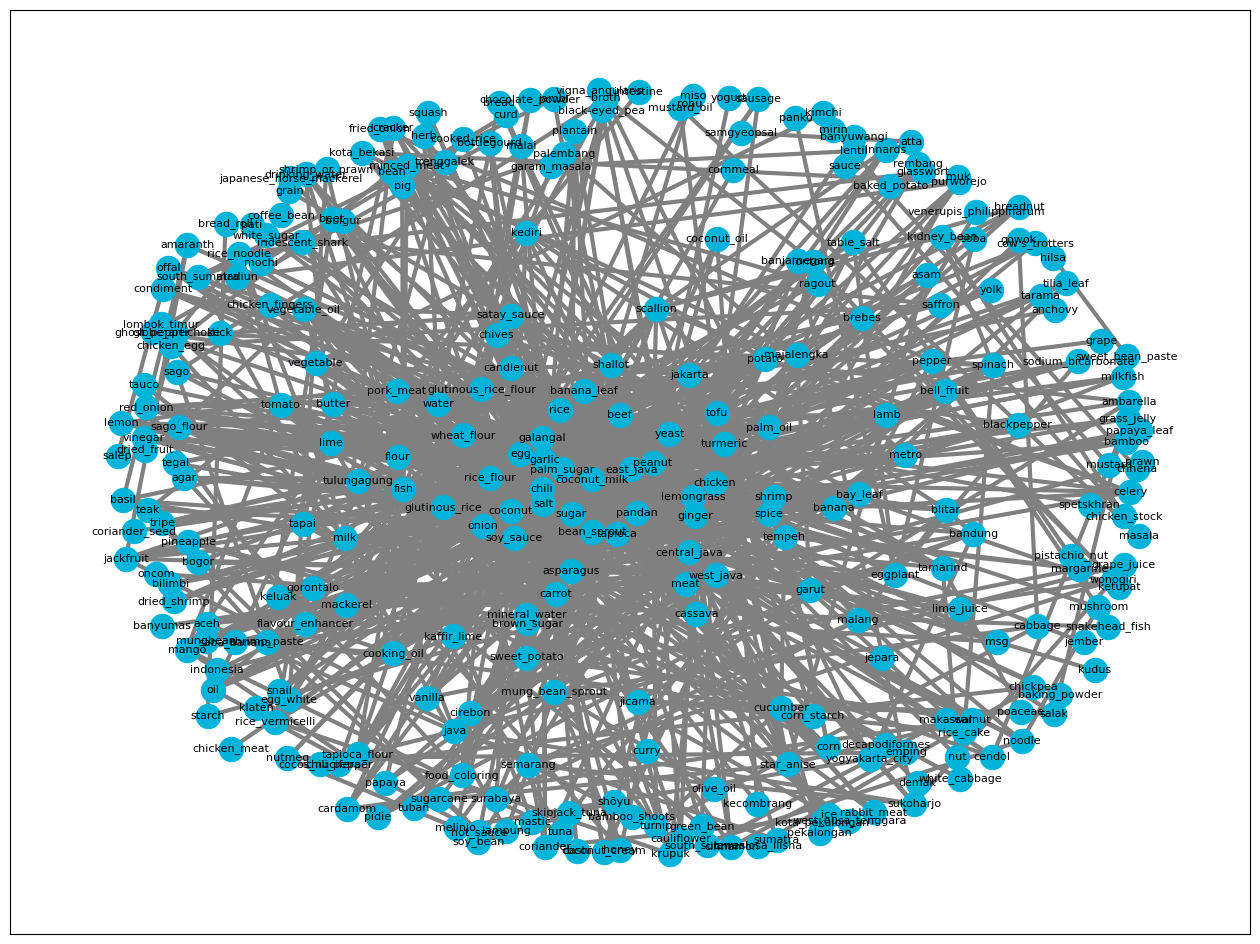

In [32]:
fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=8,
                 width=3,
                 edge_color='grey',
                 node_color='#00b4d9',
                 with_labels = True,
                 ax=ax)

plt.show()


In [33]:
weights = nx.get_edge_attributes(G,'weight').values()
len(weights)


1036

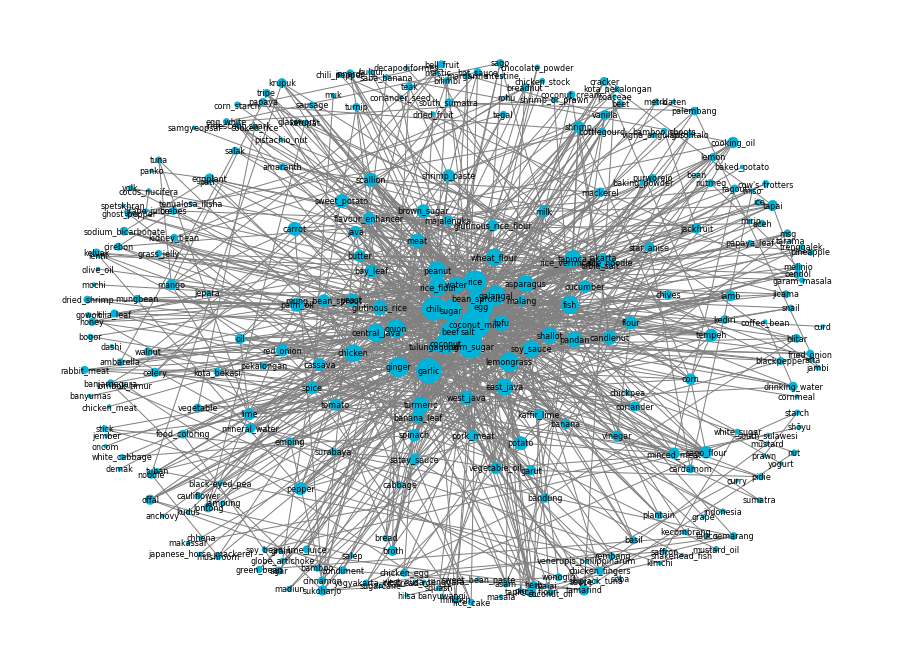

In [28]:
fig, ax = plt.subplots(figsize=(16, 12))

pos = nx.spring_layout(G, k=2)

d = dict(G.degree)

nx.draw(G, pos,
        font_size=8,
        width=1,
        edge_color='grey',
        node_color='#00b4d9',
        with_labels = True, 
        nodelist=d.keys(), 
        node_size=[v * 12 for v in d.values()])
plt.show()

In [29]:

carac = pd.DataFrame()
carac = total_ingredient[['ingredient_name','ingredient_category']]
len(d.values())

297

In [ ]:
edges = G.number_of_edges()
nodes = G.number_of_nodes()
#print(f"Number of nodes: {nodes} & number of edges: {edges}")

# community detection

In [31]:
from community import community_louvain
import matplotlib.pyplot as plt

In [32]:
comms = community_louvain.best_partition(G)
print(comms.values())

dict_values([0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 0, 0, 3, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 3, 0, 3, 3, 2, 0, 0, 2, 0, 2, 2, 1, 0, 0, 2, 2, 0, 0, 3, 0, 5, 2, 2, 0, 0, 1, 3, 3, 1, 0, 3, 3, 3, 0, 2, 1, 1, 0, 3, 1, 1, 3, 1, 1, 3, 3, 1, 2, 2, 0, 3, 2, 2, 2, 0, 3, 3, 2, 1, 3, 1, 1, 1, 1, 2, 0, 2, 7, 7, 0, 2, 1, 3, 1, 3, 0, 2, 2, 2, 8, 8, 2, 2, 2, 2, 2, 2, 5, 2, 2, 0, 2, 2, 0, 2, 2, 3, 2, 3, 3, 3, 3, 0, 1, 3, 3, 2, 1, 3, 9, 9, 0, 5, 10, 10, 5, 1, 3, 3, 5, 3, 3, 0, 5, 3, 3, 11, 3, 3, 0, 2, 5, 3, 2, 0, 11, 1, 1, 0, 2, 0, 1, 2, 5, 5, 1, 5, 2, 2, 3, 2, 2, 1, 1, 0, 12, 12, 2, 2, 2, 0, 2, 3, 3, 2, 13, 13, 2, 2, 3, 3, 10, 2, 1, 1, 2, 3, 2, 5, 5, 2, 0, 1, 1, 3, 0, 2, 0, 2, 3, 2, 0, 0, 3, 14, 14, 0, 0, 0, 3, 3, 0, 3, 3, 3, 5, 3, 2, 3, 3, 2, 3, 1, 1, 1, 11, 11, 1, 1, 3, 0, 2, 15, 15, 16, 16, 17, 17, 0, 0, 4, 4, 3, 2, 0, 2, 3, 3, 1, 3, 0, 3, 8, 8, 8, 1, 6, 6, 11, 0])


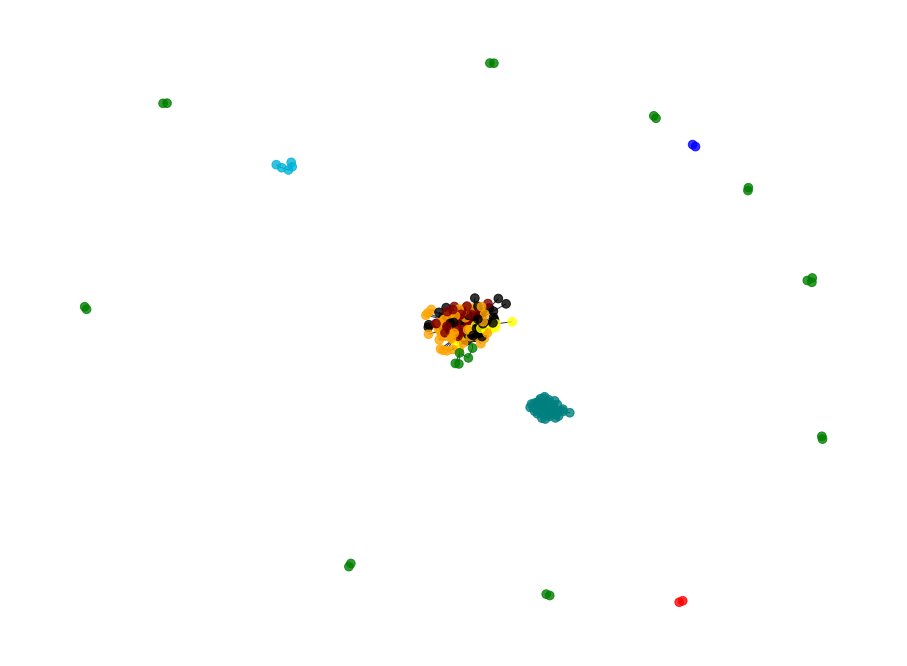

In [33]:
fig, ax = plt.subplots(figsize=(16, 12))
unique_coms = np.unique(list(comms.values()))
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'black', 
    3 : 'orange',
    4 : 'green',
    5 : 'yellow',
    6 : 'red',
    7 : 'blue',
    8 : '#00b4d9',
    9 : 'green',
    10: 'green',
    11: 'green',
    12: 'green',
    13: 'green',
    14: 'green',
    15: 'green',
    16: 'green',
    17: 'green'
}

node_cmap = [cmap[v] for _,v in comms.items()]

pos = nx.spring_layout(G)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color=node_cmap)
plt.show()

# Degree Distribution

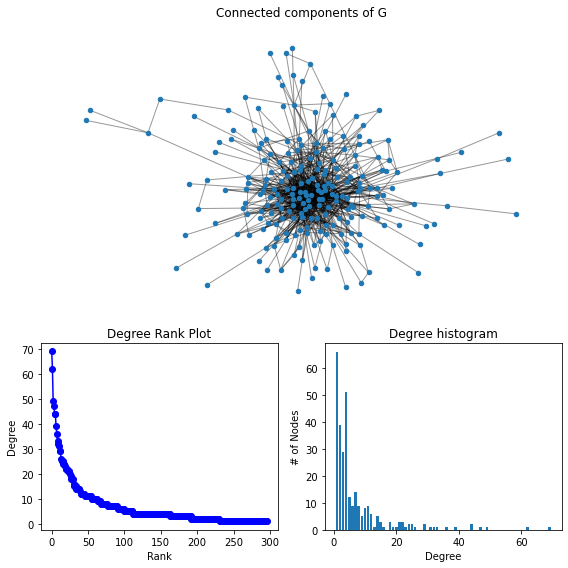

In [81]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

In [35]:
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

In [36]:
print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  297
Number of edges:  1036

Average degree:  6.976430976430977
Average degree (alternate calculation) 6.976430976430977

Minimum degree:  1
Maximum degree:  69


In [37]:
def edge_to_remove(graph):
  G_dict = nx.edge_betweenness_centrality(graph)
  edge = ()

  # extract the edge with highest edge betweenness centrality score
  for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
      edge = key
      break

  return edge

In [38]:
def girvan_newman(graph):
	# find number of connected components
	sg = nx.connected_components(graph)
	sg_count = nx.number_connected_components(graph)

	while(sg_count == 1):
		graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
		sg = nx.connected_components(graph)
		sg_count = nx.number_connected_components(graph)

	return sg

In [39]:
c = girvan_newman(G.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
  node_groups.append(list(i))

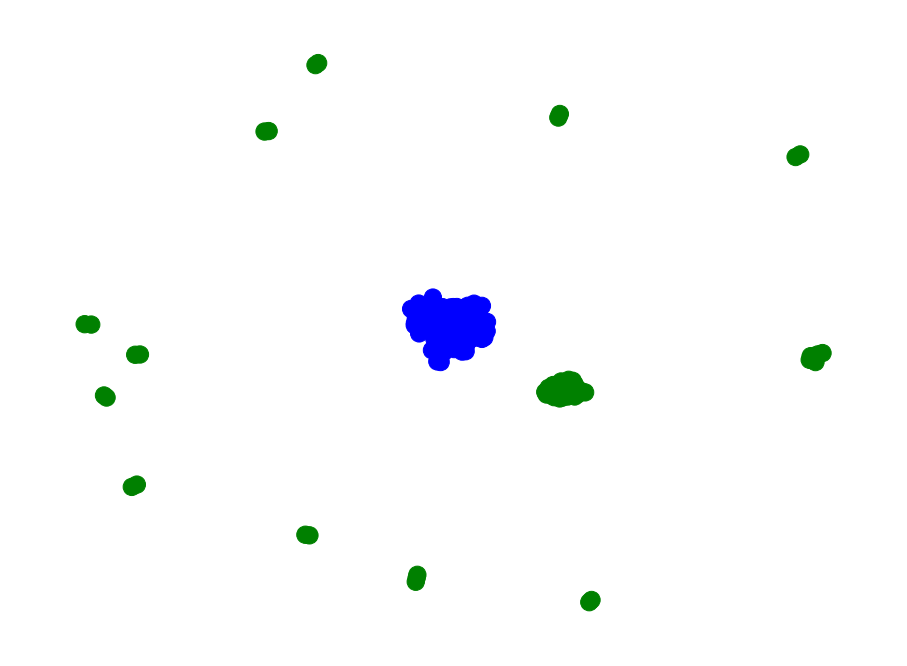

In [40]:
fig, ax = plt.subplots(figsize=(16, 12))
color_map = []
for node in G:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(G, node_color=color_map, with_labels=False)
plt.show()

# Centrality 

In [41]:
deg_centrality = nx.degree_centrality(G)

In [42]:
 {k: v for k, v in sorted(deg_centrality.items(), key=lambda item: item[1])}

{'jepara': 0.0033783783783783786,
 'coffee_bean': 0.0033783783783783786,
 'kudus': 0.0033783783783783786,
 'pati': 0.0033783783783783786,
 'kimchi': 0.0033783783783783786,
 'intestine': 0.0033783783783783786,
 'snakehead_fish': 0.0033783783783783786,
 'hilsa': 0.0033783783783783786,
 'sweet_bean_paste': 0.0033783783783783786,
 'grape': 0.0033783783783783786,
 'lentil': 0.0033783783783783786,
 'japanese_horse_mackerel': 0.0033783783783783786,
 'grain': 0.0033783783783783786,
 'mastic': 0.0033783783783783786,
 'glasswort': 0.0033783783783783786,
 'makassar': 0.0033783783783783786,
 'south_sulawesi': 0.0033783783783783786,
 'sugarcane': 0.0033783783783783786,
 'prawn': 0.0033783783783783786,
 'spetskhran': 0.0033783783783783786,
 'yogurt': 0.0033783783783783786,
 'pistachio_nut': 0.0033783783783783786,
 'poaceae': 0.0033783783783783786,
 'rohu': 0.0033783783783783786,
 'shōyu': 0.0033783783783783786,
 'skipjack_tuna': 0.0033783783783783786,
 'masala': 0.0033783783783783786,
 'lombok_timur

In [43]:
close_centrality = nx.closeness_centrality(G)


In [44]:
close_centrality

{'salt': 0.40076841547429776,
 'sugar': 0.35623859153270915,
 'coconut_milk': 0.3988134475939354,
 'rice_flour': 0.33370104798676226,
 'central_java': 0.10511039208222306,
 'jepara': 0.06378493878493878,
 'glutinous_rice': 0.3231492361927144,
 'wheat_flour': 0.33370104798676226,
 'palm_sugar': 0.38473767885532595,
 'garlic': 0.37331852400345544,
 'onion': 0.3435157846922553,
 'egg': 0.37246814012189866,
 'pandan': 0.3175019679874048,
 'water': 0.33370104798676226,
 'glutinous_rice_flour': 0.30336458907887476,
 'coconut': 0.3479010925819436,
 'chili': 0.37417279980209045,
 'cassava': 0.2972972972972973,
 'brown_sugar': 0.2994752994752995,
 'ginger': 0.3471624490732771,
 'flour': 0.30336458907887476,
 'beef': 0.3479010925819436,
 'galangal': 0.33783783783783783,
 'bandung': 0.0672327733138544,
 'west_java': 0.09328547297297297,
 'lemongrass': 0.3442389758179232,
 'garut': 0.07245473628968774,
 'east_java': 0.10365052552552552,
 'tomato': 0.30224309337063493,
 'palembang': 0.0666324806949

In [45]:
bet_centrality = nx.betweenness_centrality(G, normalized = True, endpoints = False)


In [46]:
 {k: v for k, v in sorted(bet_centrality.items(), key=lambda item: item[1])}

{'jepara': 0.0,
 'margarine': 0.0,
 'coffee_bean': 0.0,
 'kudus': 0.0,
 'tuban': 0.0,
 'pati': 0.0,
 'kimchi': 0.0,
 'kota_pekalongan': 0.0,
 'ketupat': 0.0,
 'intestine': 0.0,
 'iridescent_shark': 0.0,
 'jambi': 0.0,
 'snakehead_fish': 0.0,
 'hilsa': 0.0,
 'sweet_bean_paste': 0.0,
 'sumatra': 0.0,
 'tauco': 0.0,
 'aceh': 0.0,
 'grape': 0.0,
 'snail': 0.0,
 'lentil': 0.0,
 'japanese_horse_mackerel': 0.0,
 'grain': 0.0,
 'mastic': 0.0,
 'pig': 0.0,
 'shrimp_or_prawn': 0.0,
 'saba_banana': 0.0,
 'glasswort': 0.0,
 'gowok': 0.0,
 'pidie': 0.0,
 'makassar': 0.0,
 'south_sulawesi': 0.0,
 'sugarcane': 0.0,
 'prawn': 0.0,
 'spetskhran': 0.0,
 'squash': 0.0,
 'sausage': 0.0,
 'yogurt': 0.0,
 'pistachio_nut': 0.0,
 'plantain': 0.0,
 'poaceae': 0.0,
 'rohu': 0.0,
 'white_cabbage': 0.0,
 'trenggalek': 0.0,
 'yolk': 0.0,
 'shōyu': 0.0,
 'skipjack_tuna': 0.0,
 'madiun': 0.0,
 'masala': 0.0,
 'metro': 0.0,
 'lampung': 0.0,
 'lombok_timur': 0.0,
 'west_nusa_tenggara': 0.0,
 'milkfish': 0.0,
 'salep':

In [47]:
pr = nx.pagerank(G, alpha = 0.8)


In [48]:
 {k: v for k, v in sorted(pr.items(), key=lambda item: item[1])}

{'coriander_seed': 0.0008290234880874947,
 'chicken_meat': 0.0008296513137671182,
 'baked_potato': 0.0008304076761945836,
 'cornmeal': 0.0008404511397316031,
 'japanese_horse_mackerel': 0.0008531036837627401,
 'decapodiformes': 0.0008687097584820564,
 'oncom': 0.00087333756740123,
 'sugarcane': 0.0008953262427697432,
 'mastic': 0.0008972655215138019,
 'grape': 0.0008974869151437374,
 'spetskhran': 0.0008974869151437374,
 'anchovy': 0.0008974869151437374,
 'muk': 0.000918382491140752,
 'rohu': 0.000922476376933463,
 'yogurt': 0.000930168715407945,
 'intestine': 0.0009575997183770418,
 'salep': 0.0009774865456083674,
 'chocolate_powder': 0.00098795143077083,
 'baking_powder': 0.0009923479057892758,
 'yolk': 0.001027657718162538,
 'black-eyed_pea': 0.001030371087258646,
 'banyumas': 0.0010371399307622232,
 'demak': 0.0010371399307622232,
 'klaten': 0.0010371399307622232,
 'snakehead_fish': 0.0010491953250587331,
 'miso': 0.0010632443154927848,
 'banyuwangi': 0.001065516722726265,
 'jember

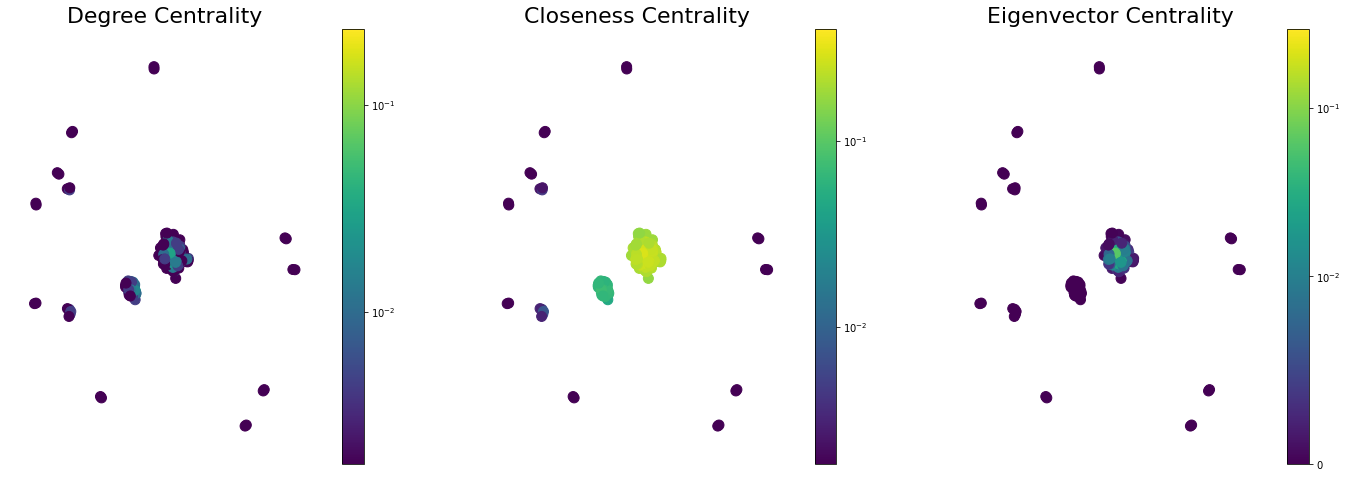

In [49]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import community
import matplotlib
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from collections import Counter

pos =  nx.spring_layout(G)
matplotlib.rcParams['figure.figsize']= [24, 8]
def draw(G, pos, lista, listb, measure_name):
    nodes=nx.draw_networkx_nodes(G, pos, node_size=100, cmap=plt.cm.viridis,node_color=lista,nodelist=listb)
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    edges=nx.draw_networkx_edges(G, pos)
    plt.title(measure_name, fontsize=22)
    plt.colorbar(nodes)
    plt.axis('off')

plt.subplot(1,3,1)
list_pos_values = []
for i in nx.degree_centrality(G).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.degree_centrality(G).keys():
    list_pos_keys.append(i)
draw(G, pos, list_pos_values, list_pos_keys, 'Degree Centrality')

plt.subplot(1,3,2)
list_pos_values=[]
for i in nx.closeness_centrality(G).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.closeness_centrality(G).keys():
    list_pos_keys.append(i)
draw(G, pos, list_pos_values, list_pos_keys, 'Closeness Centrality')

plt.subplot(1,3,3)
list_pos_values=[]
for i in nx.eigenvector_centrality(G).values():
    list_pos_values.append(i)
    list_pos_keys=[]
for i in nx.eigenvector_centrality(G).keys():
    list_pos_keys.append(i)
draw(G, pos, list_pos_values, list_pos_keys, 'Eigenvector Centrality')


In [50]:
partition=community.best_partition(G, weight='MsgCount')
print('Completed Louvain algorithm .. . . ' )
values=[partition.get(node) for node in G.nodes()]
list_com=partition.values()

# Creating a dictionary like {community_number:list_of_participants}
dict_nodes={}

# Populating the dictionary with items
for each_item in partition.items():
    community_num=each_item[1]
    community_node=each_item[0]
    if community_num in dict_nodes:
        value=dict_nodes.get(community_num) + ' | ' + str(community_node)
        dict_nodes.update({community_num:value})
    else:
        dict_nodes.update({community_num:community_node})

# Creating a dataframe from the diet, and getting the output into excel
community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
community_df.index.rename('Community_Num' , inplace=True)
community_df.to_csv('Community_List_snippet.csv')

Completed Louvain algorithm .. . . 


Modularity:  0.430163377300136
Total number of Communities= 19


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


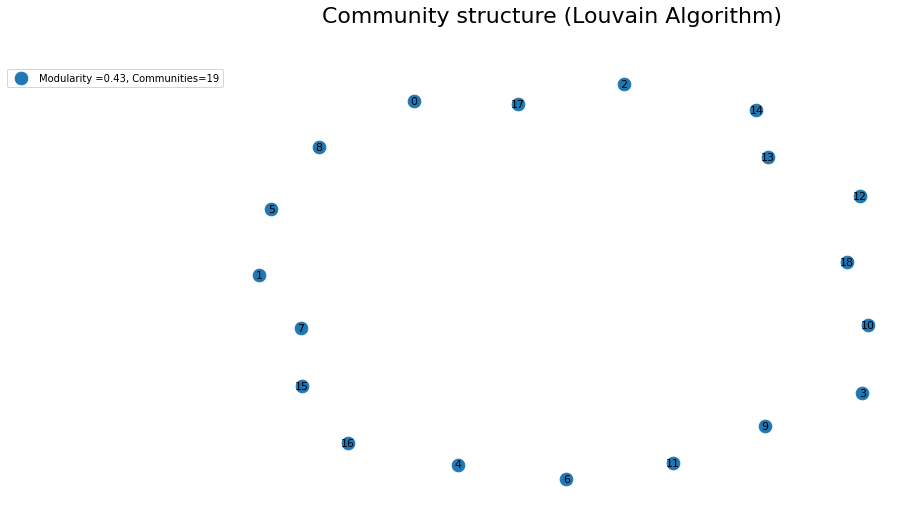

In [51]:
# Creating a new graph to represent the communities created by the Louvain algorithm
matplotlib.rcParams['figure.figsize']= [12, 8]
G_comm=nx.Graph()

# Populating the data from the node dictionary created earlier
G_comm.add_nodes_from(dict_nodes)

# Calculating modularity and the total number of communities
mod=community.modularity(partition,G)
print("Modularity: ", mod)
print("Total number of Communities=", len(G_comm.nodes()))

# Creating the Graph and also calculating Modularity
matplotlib.rcParams['figure.figsize']= [12, 8]
pos_louvain=nx.spring_layout(G_comm)
nx.draw_networkx(G_comm, pos_louvain, with_labels=True,node_size=160,font_size=11,label='Modularity =' + str(round(mod,3)) +
                    ', Communities=' + str(len(G_comm.nodes())))
plt.suptitle('Community structure (Louvain Algorithm)',fontsize=22,fontname='Arial')
plt.box(on=None)
plt.axis('off')
plt.legend(bbox_to_anchor=(0,1), loc='best', ncol=1)
plt.savefig('louvain.png',dpi=400, bbox_inches='tight')

In [52]:
community_df


Members
Community_Num                                                   
0              salt | sugar | coconut_milk | rice_flour | glu...
3              central_java | jepara | bandung | west_java | ...
2              garlic | onion | water | chili | ginger | beef...
4              tomato | oil | lime | shrimp_paste | hot_sauce...
6              soy_sauce | rice | tofu | asparagus | bean_spr...
7              scallion | chicken | pepper | potato | spinach...
9                                       hilsa | sweet_bean_paste
10             garam_masala | lentil | chickpea | chili_peppe...
11                                     makassar | south_sulawesi
12                                   prawn | starch | bread_roll
5              white_sugar | saffron | bean | chicken_egg | d...
15                             lombok_timur | west_nusa_tenggara
16                                               mustard | sauce
17                                            atta | samgyeopsal
18                                                  curd | mochi
8                                curry | venerupis_philippinarum
1                                                  dashi | malai
13                                  cocos_nucifera | grape_juice
14                                                chhena | mirin

## Comunity with Louviin Algorithm

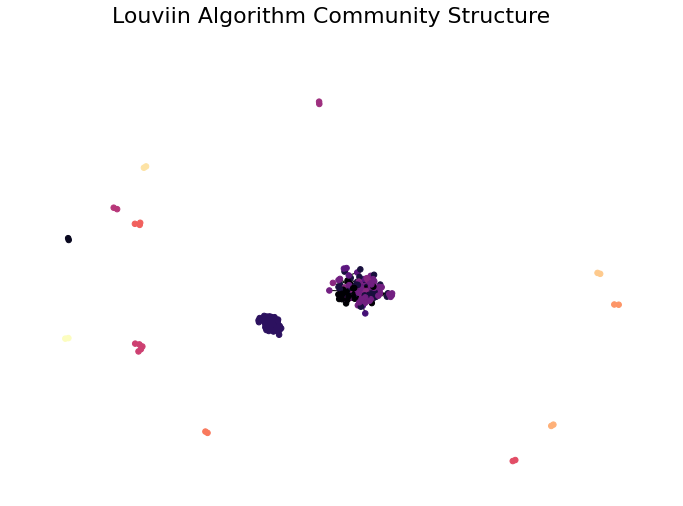

In [53]:
nx.draw_networkx(G, pos, cmap=plt.get_cmap('magma'), node_color=values,node_size=30, with_labels=False)
plt.suptitle('Louviin Algorithm Community Structure',fontsize=22)
plt.box(on=None)
plt.axis('off')
plt.show()

In [54]:
from networkx.algorithms.community.centrality import girvan_newman
comp=girvan_newman(G)

In [ ]:
com=0
thisdict={}

# Populating the items of the dictionary
for c in next(comp):
    list=sorted(c)
    for i in range(len(list)):
        if list[i] in thisdict:
            print('already found')
        else:
            thisdict.update({list[i]: com})
        i+=1
    com+=1

values_girvan=[thisdict.get(node) for node in G.nodes()]
values_girvan


In [57]:
G.neighbors('salt')

In [58]:
for node in G.neighbors('salt'): 
    print(f"Node: {node}")

Node: sugar
Node: coconut_milk
Node: garlic
Node: water
Node: egg
Node: chili
Node: rice_flour
Node: glutinous_rice_flour
Node: glutinous_rice
Node: soy_sauce
Node: rice
Node: palm_oil
Node: palm_sugar
Node: shallot
Node: coconut
Node: flour
Node: oil
Node: lime
Node: pandan
Node: blackpepper
Node: food_coloring
Node: lemongrass
Node: butter
Node: vinegar
Node: drinking_water
Node: tomato
Node: tapioca
Node: banana
Node: beef
Node: wheat_flour
Node: hot_sauce
Node: galangal
Node: flavour_enhancer
Node: fish
Node: potato
Node: peanut
Node: plantain
Node: pork_meat
Node: shrimp
Node: sodium_bicarbonate
Node: sweet_potato
Node: tapioca_flour
Node: tempeh
Node: vanilla
Node: vegetable
Node: walnut
Node: mango
Node: margarine
Node: meat
Node: milk
Node: lamb
Node: offal
Node: mineral_water
Node: msg
Node: noodle
Node: beet
Node: carrot
Node: cardamom
Node: agar
Node: corn
Node: cucumber
Node: cooking_oil


# number of connected nodes

In [59]:
nx.number_connected_components(G)

14

In [60]:
nx.connected_components(G)

<generator object connected_components at 0x7fd20a23f8d0>

In [61]:
nx.write_gml(G, "food.gml")

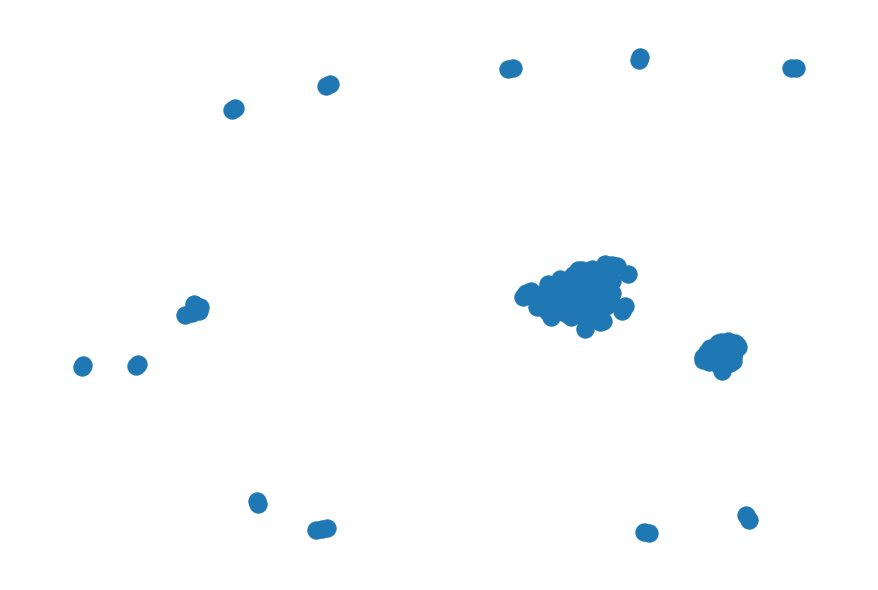

In [62]:
labels = {
    n: (G.nodes[n]['label']
        if len([nx.all_neighbors(G, n)]) > 30
        else '')
    for n in G.nodes
}
nx.draw(G, with_labels=True, labels=labels)

In [ ]:
def plot_degree_dist(G):
    
    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=20)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=20)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6,4))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

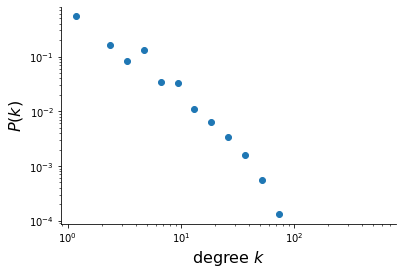

In [64]:
plot_degree_dist(G)

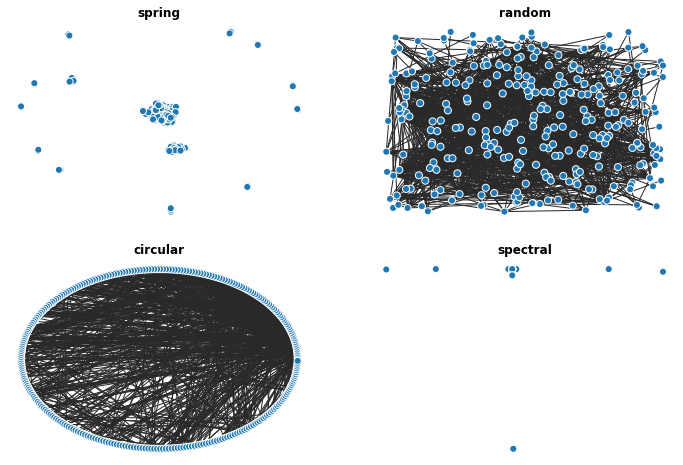

In [65]:
#https://towardsdatascience.com/discovering-entity-connections-insights-using-network-analytics-part-
# this visualization was taken from here
from grave import grave

fig, axes = plt.subplots(nrows=2, ncols=2)

grave.plot_network(G, ax=axes[0, 0], layout="spring")
axes[0, 0].set_title("spring", fontweight="bold")

grave.plot_network(G, ax=axes[1, 0], layout="circular")
axes[1, 0].set_title("circular", fontweight="bold")

grave.plot_network(G, ax=axes[0, 1], layout="random")
axes[0, 1].set_title("random", fontweight="bold")

grave.plot_network(G, ax=axes[1, 1], layout="spectral")
axes[1, 1].set_title("spectral", fontweight="bold")

plt.show()

## Visualizing th enetwork with different Library

In [66]:
# Compute the degree centralities of G:
degree_cent = nx.degree_centrality(G)
# Compute the maximum degree centrality: 
max_degree_cent = max(degree_cent.values())
# Find the item(s) that have highest co-occurrence
highest_cooccurrence = [n for n, dc in degree_cent.items() if dc == max_degree_cent]

print(highest_cooccurrence)

['coconut_milk']


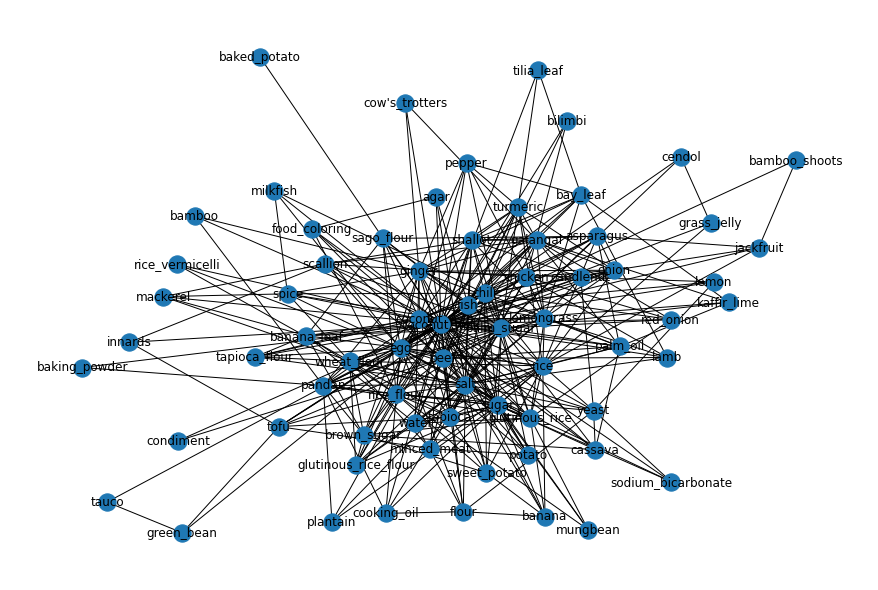

In [104]:
def get_nbrs(G, nodes_of_interest):
    """
    Returns a subgraph of the graph `G` with only the `nodes_of_interest` and their neighbors.
    """
    nodes_to_draw = []
    # Iterate over the nodes of interest
    for n in nodes_of_interest:
        # Append the nodes of interest to nodes_to_draw
        nodes_to_draw.append(n)
        for nbr in G.neighbors(n):
            # Append the neighbors of n to nodes_to_draw
            nodes_to_draw.append(nbr)
    return G.subgraph(nodes_to_draw)

# Extract the subgraph with the nodes of interest:
T_draw = get_nbrs(G, ['coconut_milk'])

# Draw the subgraph
nx.draw(T_draw, with_labels=True)
plt.show()

In [68]:
!pip install pyvis


In [69]:
from pyvis.network import Network

net = Network(notebook=True)
net.from_nx(G)
#net.show("gruyereCheese.html")
#net.show('mygraph.html')
net.show('g3.html')


Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [70]:
from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(G, dimensions=2, walk_length=20, num_walks=10,workers=4)
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)
#model.wv.most_similar('1')
model.wv.save_word2vec_format("embedding.emb")

Computing transition probabilities:   0%|          | 0/297 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

In [71]:
!pip install node2vec

In [72]:
!pip install motifcluster


## finding the shortest path for each community

In [82]:
from statistics import mean
import networkx as nx
import random


def write_nodes_number_and_shortest_paths(graph_, n_samples=10_000,
                                          output_path='graph_info_output.txt'):
    with open(output_path, encoding='utf-8', mode='w+') as f:
        for component in nx.connected_components(graph_):
            component_ = graph_.subgraph(component)
            nodes = component_.nodes()
            lengths = []
            for _ in range(n_samples):
                n1, n2 = random.choices(list(nodes), k=2)
                length = nx.shortest_path_length(component_, source=n1, target=n2)
                lengths.append(length)
            f.write(f'Nodes num: {len(nodes)}, shortest path mean: {mean(lengths)} \n')


In [84]:
import networkx as nx
import logging


def fetch_hugest_subgraph(graph_):
    Gcc = max(nx.connected_components(graph_), key=len)
    giantC = graph_.subgraph(Gcc)
    logging.info('Fetched Giant Subgraph')
    return giantC

In [87]:
gi = fetch_hugest_subgraph(G)

In [92]:
nx.average_shortest_path_length(gi)


2.8361579596873714

In [111]:
avg = nx.average_neighbor_degree(gi)
deg = gi.degree()
{k: v for k, v in sorted(deg, key=lambda item: item[1])}


{'coffee_bean': 1,
 'kimchi': 1,
 'intestine': 1,
 'snakehead_fish': 1,
 'grape': 1,
 'japanese_horse_mackerel': 1,
 'grain': 1,
 'mastic': 1,
 'glasswort': 1,
 'sugarcane': 1,
 'spetskhran': 1,
 'yogurt': 1,
 'pistachio_nut': 1,
 'poaceae': 1,
 'rohu': 1,
 'shōyu': 1,
 'skipjack_tuna': 1,
 'masala': 1,
 'salep': 1,
 'muk': 1,
 'olive_oil': 1,
 'tarama': 1,
 'oncom': 1,
 'miso': 1,
 'baked_potato': 1,
 'anchovy': 1,
 'bean': 1,
 'cornmeal': 1,
 'coriander_seed': 1,
 'decapodiformes': 1,
 'panko': 1,
 'soba': 1,
 'chicken_meat': 1,
 'dried_fruit': 1,
 'ketupat': 2,
 'tauco': 2,
 'pig': 2,
 'shrimp_or_prawn': 2,
 'saba_banana': 2,
 'globe_artichoke': 2,
 'gowok': 2,
 'squash': 2,
 'white_sugar': 2,
 'white_cabbage': 2,
 'saffron': 2,
 'yolk': 2,
 'soy_bean': 2,
 'mustard_oil': 2,
 'vigna_angularis': 2,
 'nut': 2,
 'bulgur': 2,
 'black-eyed_pea': 2,
 'papaya_leaf': 2,
 'baking_powder': 2,
 'bamboo_shoots': 2,
 'kecombrang': 2,
 'corn_starch': 2,
 'cooked_rice': 2,
 'chicken_stock': 2,
 'c

In [102]:
gi.number_of_nodes()

221

# Comparing to null models

In [34]:
number_of_node = len(G.nodes())
# number of edges in complete graph
max_L = number_of_node * (number_of_node-1)/2
# number of actual node of graph
actual_L = len(G.edges())

p = actual_L/max_L
import networkx.algorithms.community as nx_comm
C = np.mean(list(nx.clustering(G).values()))
print("Average Clustering Coefficient: ", C)
std = np.std(list(nx.clustering(G).values()))
print("Average Clustering Coefficient: ", std)
cc = nx.number_connected_components(G)
print("cc: ", cc)
m = nx_comm.modularity(G, nx_comm.label_propagation_communities(G))
print(m)

Average Clustering Coefficient:  0.3906522571303857
Average Clustering Coefficient:  0.33542906218420104
cc:  14
0.1990746132657209


## Comparing to an Erdös-Renyi graph of similar size

In [35]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [ ]:
# This is just one instance of a random graph. We need to create an ensemble.
# Using random weights
from scipy import stats
import random as rand

clustering_ER = []
short_path_ER = []
cc_list= []
m_list = []

for i in range(3000): # 1000 is better
    
    ER = nx.erdos_renyi_graph(number_of_node, p, directed=False)
    for (u, v) in ER.edges():
        ER.edges[u,v]['weight'] = rand.randint(10,220) 
        cc = nx.number_connected_components(ER)
        cc_list.append(cc)
        

    C_ER = nx.average_clustering(ER)
    if nx.is_connected(ER)==True:
        d_ER = nx.average_shortest_path_length(ER,weight=None)
    clustering_ER.append(C_ER)
    short_path_ER.append(d_ER)
    m = nx_comm.modularity(ER, nx_comm.label_propagation_communities(ER))
    m_list.append(m)
    
print(np.mean(clustering_ER))
print(np.std(clustering_ER))

print(np.mean(short_path_ER))
print(np.std(short_path_ER))
print(stats.mode(cc_list))

print(np.mean(m_list))
print(np.std(m_list))


In [ ]:
DP = G.copy() # the function edits the graph in place

nx.double_edge_swap(DP,nswap=10*G.number_of_edges(),max_tries=100000)

In [ ]:
from scipy import stats


clustering_DP = []
short_path_DP = []
cc_list= []

for i in range(1000): # 1000 is better
    
    nx.double_edge_swap(DP,nswap=10*G.number_of_edges(),max_tries=100000)
    C_DP = np.mean(list(nx.clustering(DP).values()))
    clustering_DP.append(C_DP)
    cc = nx.number_connected_components(DP)
    cc_list.append(cc)
    if nx.is_connected(DP)==True:
        d_DP = nx.average_shortest_path_length(DP,weight=None)
        short_path_DP.append(d_DP)
    
    
    
print(np.mean(clustering_DP))
print(np.std(clustering_DP))

print(np.mean(short_path_DP))
print(np.std(short_path_DP))
print(stats.mode(cc_list))

In [ ]:
fig = plt.figure(figsize=(6,4))
plot_degree_dist(DP , "blue")
plot_degree_dist(G , "green")
plot_degree_dist(ER , "red")
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4))
my_dict = { 'G':[C],'DP': clustering_DP,'ER': clustering_ER}
fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
plt.show()